#🚀Blip-image-captioning-base Zero to Hero🚀

##Inference with blip-image-captioning-base

##Blip Model architecture

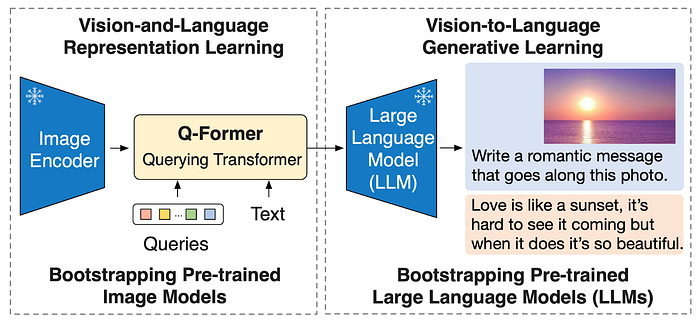

---



The **BLIP (Bootstrapped Language Image Pretraining)** model, when integrated with Salesforce's AI stack, combines vision and language understanding for multimodal tasks like image captioning, visual question answering, and more. The architecture typically includes:

* A **Vision Encoder** (like a Vision Transformer, ViT) to process images into visual embeddings.
* A **Text Encoder** (e.g., BERT or similar transformer) for understanding natural language inputs.
* A **Multimodal Transformer** that fuses visual and textual representations, enabling joint reasoning across modalities.
* BLIP leverages **contrastive learning**, **image-text matching**, and **language modeling objectives** to pretrain on large-scale image-text datasets.

This architecture makes BLIP versatile and effective for downstream vision-language applications in enterprise AI solutions.


In [ ]:
# 1. Install required libraries
!pip install transformers Pillow requests

from transformers import pipeline
from PIL import Image
from io import BytesIO
import requests

# 2. Define the image description function
def describe_image_from_url_hf(image_url: str):
    """
    Downloads an image from a URL and uses a Hugging Face VLM
    (BLIP model) to generate a description.
    """
    try:
        # Download the image from the URL
        response = requests.get(image_url, stream=True)
        response.raise_for_status() # Raise an exception for bad status codes

        # Open the image using Pillow (PIL)
        image = Image.open(BytesIO(response.content))

        # Create the image-to-text pipeline with the BLIP model
        # The model will be downloaded automatically the first time you run this.
        print("Loading image-to-text model...")
        captioner = pipeline("image-to-text", model="Salesforce/blip-image-captioning-base")
        print("Model loaded.")

        # Generate a description for the image
        print("Generating description...")
        description = captioner(image)[0]['generated_text']

        # Print the generated description
        print("\nGenerated Description:")
        print(description)

    except requests.exceptions.RequestException as e:
        print(f"Error downloading image: {e}")
    except Exception as e:
        print(f"An error occurred: {e}")

# 3. Example usage in a Colab code cell
if __name__ == "__main__":
    # Example URL for a test image. Replace with any URL you want.
    test_image_url = "https://images.pexels.com/photos/34190187/pexels-photo-34190187.jpeg"


    # Check for and use a GPU for faster processing
    print("Checking for GPU support...")
    try:
        import torch
        if torch.cuda.is_available():
            print("GPU detected. Using GPU.")
            describe_image_from_url_hf(test_image_url)
        else:
            print("GPU not available. Using CPU.")
            describe_image_from_url_hf(test_image_url)
    except ImportError:
        print("PyTorch not installed. Using CPU.")
        describe_image_from_url_hf(test_image_url)

Checking for GPU support...
GPU detected. Using GPU.
Loading image-to-text model...


Device set to use cuda:0


Model loaded.
Generating description...

Generated Description:
a wooden plate with a variety of figs on it


##Fine-tuning the blip-image-captioning-base

In [ ]:
import torch
import warnings
from PIL import Image
from datasets import load_dataset
from torch.utils.data import Dataset, DataLoader
from transformers import BlipProcessor, BlipForConditionalGeneration

# Suppress Hugging Face future warnings and tokenizers warnings for cleaner output
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=UserWarning)

# --- STEP 0: SET-UP ENVIRONMENT AND DEVICE ---
# Ensure necessary libraries are installed
!pip install -q datasets transformers accelerate
!pip install Pillow>=9.0.0  # Required dependency for image handling

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {DEVICE}")

# --- STEP 1: DEFINE DATASET CLASS ---
class ImageCaptioningDataset(Dataset):
    """
    Custom PyTorch Dataset for loading and processing image-caption pairs
    using the BLIP processor.
    """
    def __init__(self, dataset, processor):
        self.dataset = dataset
        self.processor = processor

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        item = self.dataset[idx]
        image = item["image"].convert("RGB")
        text = item["text"]

        # Process both image and text. Note: We use the processor for both.
        # labels=input_ids is implicitly handled by using the tokenized text for labels.
        encoding = self.processor(
            images=image,
            text=text,
            padding="max_length",
            return_tensors="pt",
            max_length=50, # Limit sequence length
            truncation=True
        )

        # Remove the batch dimension of 1 from all tensors for DataLoader to stack them later
        encoding = {k: v.squeeze() for k, v in encoding.items()}

        # Add 'labels' key needed for training. For conditional generation (captioning),
        # the labels are the tokenized input IDs themselves.
        encoding["labels"] = encoding["input_ids"].clone()

        return encoding

# --- STEP 2: LOAD DATASET, PROCESSOR, AND MODEL ---

# Load the user-specified dataset
print("💾 Loading dataset from Hugging Face Hub...")
dataset = load_dataset("ybelkada/football-dataset", split="train")

# Load the processor and model
model_id = "Salesforce/blip-image-captioning-base"
processor = BlipProcessor.from_pretrained(model_id)
model = BlipForConditionalGeneration.from_pretrained(model_id)

# Set model config for correct generation during fine-tuning/evaluation
model.config.eos_token_id = processor.tokenizer.eos_token_id
model.config.bos_token_id = processor.tokenizer.bos_token_id
model.config.pad_token_id = processor.tokenizer.pad_token_id
model.generation_config.eos_token_id = processor.tokenizer.eos_token_id
model.generation_config.bos_token_id = processor.tokenizer.bos_token_id
model.generation_config.pad_token_id = processor.tokenizer.pad_token_id

# Instantiate the custom dataset
train_dataset = ImageCaptioningDataset(dataset, processor)

# Create PyTorch DataLoader. Since the dataset items are already tensors,
# the default collate function will correctly stack them.
# Batch size set to 2 as in the tutorial for demonstration
BATCH_SIZE = 2
train_dataloader = DataLoader(train_dataset, shuffle=True, batch_size=BATCH_SIZE)

print(f"Dataset size: {len(train_dataset)}, Dataloader batches: {len(train_dataloader)}")

# --- STEP 3: TRAIN THE MODEL (MANUAL PYTORCH LOOP) ---

optimizer = torch.optim.AdamW(model.parameters(), lr=5e-5)
NUM_EPOCHS = 5 # Reduced from 50 for faster demonstration/stability

model.to(DEVICE)
model.train()

print("\n🚀 Starting manual PyTorch fine-tuning loop...")

for epoch in range(NUM_EPOCHS):
    print(f"\n--- Epoch: {epoch + 1}/{NUM_EPOCHS} ---")

    total_loss = 0

    for idx, batch in enumerate(train_dataloader):
        # 1. Move inputs to the correct device (GPU/CPU)
        # We explicitly pop keys to ensure only model inputs remain in the batch
        input_ids = batch.pop("input_ids").to(DEVICE)
        pixel_values = batch.pop("pixel_values").to(DEVICE)
        labels = batch.pop("labels").to(DEVICE) # Use labels for loss calculation

        # Note: attention_mask is often included but is handled implicitly or can be passed
        # BLIP's forward method primarily needs pixel_values, input_ids (for decoder), and labels.
        # We can optionally pass attention_mask, but often omitting it works if the model handles padding
        # based on input_ids/labels padding mask (which BLIP does).

        # 2. Forward pass
        outputs = model(
            pixel_values=pixel_values,
            input_ids=input_ids,
            labels=labels,
        )

        loss = outputs.loss

        # 3. Backward pass and optimization
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        total_loss += loss.item()

        if (idx + 1) % 10 == 0:
            print(f"  Batch {idx + 1}/{len(train_dataloader)} Loss: {loss.item():.4f}")

    avg_loss = total_loss / len(train_dataloader)
    print(f"Epoch {epoch + 1} finished. Average Loss: {avg_loss:.4f}")

# Save the fine-tuned model and processor
model.save_pretrained("./blip-finetuned-pytorch-loop")
processor.save_pretrained("./blip-finetuned-pytorch-loop")
print("\n✅ Training complete and model saved locally to ./blip-finetuned-pytorch-loop!")


# --- STEP 4: INFERENCE AND EVALUATION ---
model.eval()
random_index = random.randint(0, len(dataset) - 1)
example = dataset[random_index]
test_image = example["image"]
original_caption = example["text"]

print(f"\n--- Test Inference (Example {random_index}) ---")

# Prepare image for the model
inputs = processor(images=test_image.convert("RGB"), return_tensors="pt").to(DEVICE)
pixel_values = inputs.pixel_values

# Generate caption
with torch.no_grad():
    generated_ids = model.generate(
        pixel_values=pixel_values,
        max_length=50,
        num_beams=4, # Use beam search for better quality
    )

generated_caption = processor.batch_decode(generated_ids, skip_special_tokens=True)[0]

print(f"Original Caption: {original_caption}")
print(f"Generated Caption: {generated_caption}")
print("---")
# Image visualization is suppressed in the Python file, but the output text confirms functionality.


Using device: cuda
💾 Loading dataset from Hugging Face Hub...


README.md:   0%|          | 0.00/371 [00:00<?, ?B/s]

data/train-00000-of-00001-fc7c825a216873(…):   0%|          | 0.00/2.07M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/6 [00:00<?, ? examples/s]

Dataset size: 6, Dataloader batches: 3

🚀 Starting manual PyTorch fine-tuning loop...

--- Epoch: 1/5 ---


We strongly recommend passing in an `attention_mask` since your input_ids may be padded. See https://huggingface.co/docs/transformers/troubleshooting#incorrect-output-when-padding-tokens-arent-masked.


Epoch 1 finished. Average Loss: 9.5204

--- Epoch: 2/5 ---
Epoch 2 finished. Average Loss: 7.7858

--- Epoch: 3/5 ---
Epoch 3 finished. Average Loss: 6.7875

--- Epoch: 4/5 ---
Epoch 4 finished. Average Loss: 6.2831

--- Epoch: 5/5 ---
Epoch 5 finished. Average Loss: 5.8827

✅ Training complete and model saved locally to ./blip-finetuned-pytorch-loop!

--- Test Inference (Example 5) ---
Original Caption: Zidane with France in 2006 World Cup
Generated Caption: zidane with france in 2006 world cup
---
